In [1]:
!pip install pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 281.4/281.4 MB 3.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... - \ done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.7/199.7 kB 13.2 MB/s eta 0:00:00
  Created wheel for pyspark: filename=pyspark-3.3.1-py2.py3-none-any.whl size=281845513 sha256=85d5fd52fb348e225d072271dcaa8af07cc92a6731515fe69e6ff65ef482e65a
  Stored in directory: /root/.cache/pip/wheels/42/59/f5/79a5bf931714dcd201b26025347785f087370a10a3329a899c
Successfully built pyspark
  Attempting uninstall: py4j
    Found existing installation: py4j 0.10.9.7
    Uninstalling py4j-0.10.9.7:
      Successfully uninstalled py4j-0.10.9.7


In [2]:
import os
import pandas as pd
import numpy as np

from pyspark import SparkConf, SparkContext
from pyspark.sql import SparkSession, SQLContext

from pyspark.sql.types import *
import pyspark.sql.functions as F
from pyspark.sql.functions import udf, col

from pyspark.ml.regression import LinearRegression
from pyspark.mllib.evaluation import RegressionMetrics

from pyspark.ml.tuning import ParamGridBuilder, CrossValidator, CrossValidatorModel
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.evaluation import RegressionEvaluator

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt

In [4]:
# setting random seed for notebook reproducability
rnd_seed=23
np.random.seed=rnd_seed
np.random.set_state=rnd_seed

#### Creating spark session

In [5]:
spark = SparkSession.builder.master("local[2]").appName("Spaceship_rescue").getOrCreate()
sc = spark.sparkContext
sqlContext = SQLContext(spark.sparkContext)
spark

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


22/11/04 23:12:19 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


/opt/conda/lib/python3.7/site-packages/pyspark/sql/context.py:114: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  FutureWarning,


#### Read the data

In [6]:
train_data = '../input/spaceship-titanic/train.csv'
test_data = '../input/spaceship-titanic/test.csv'
df_train = spark.read.csv(train_data, header=True)
df_test = spark.read.csv(test_data, header=True)

#### Explore and clean the data

In [7]:
df_train.columns

['PassengerId',
 'HomePlanet',
 'CryoSleep',
 'Cabin',
 'Destination',
 'Age',
 'VIP',
 'RoomService',
 'FoodCourt',
 'ShoppingMall',
 'Spa',
 'VRDeck',
 'Name',
 'Transported']

In [8]:
df_train.count()

8693

#### Number of people with similar age group

<AxesSubplot:xlabel='age'>

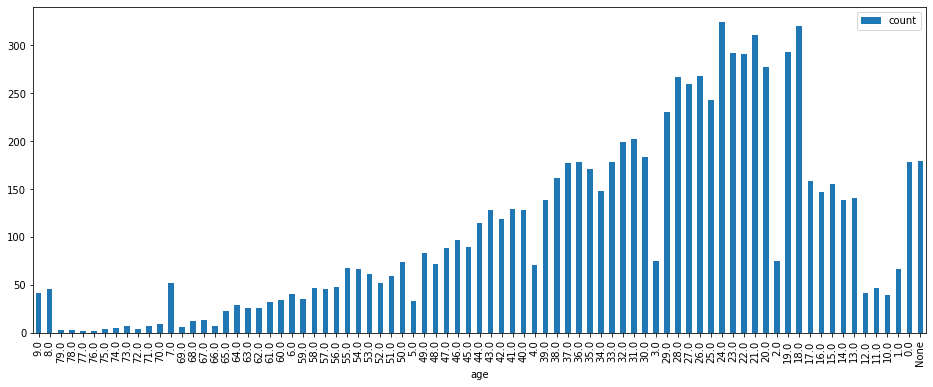

In [9]:
result_df = df_train.groupBy("age").count().sort("age", ascending=False)
result_df.toPandas().plot.bar(x='age',figsize=(16, 6))

#### Count of people travelling from HomePlanet

In [10]:
df_train.groupBy("HomePlanet").count().sort("HomePlanet", ascending=False).show()

+----------+-----+
|HomePlanet|count|
+----------+-----+
|      Mars| 1759|
|    Europa| 2131|
|     Earth| 4602|
|      null|  201|
+----------+-----+



#### Number of people under CryoSleep

In [11]:
df_train.groupBy("CryoSleep").count().sort("CryoSleep", ascending=False).show()

+---------+-----+
|CryoSleep|count|
+---------+-----+
|     True| 3037|
|    False| 5439|
|     null|  217|
+---------+-----+



This shows that, we do not have data for 217 pepole whether they are in cryosleep or not!

#### Count of Null Values in our data

In [12]:
from pyspark.sql.functions import col,isnan,when,count
df2 = df_train.select([count(when(col(c).contains('None') | \
                            col(c).contains('NULL') | \
                            (col(c) == '' ) | \
                            col(c).isNull() | \
                            isnan(c), c 
                           )).alias(c)
                    for c in df_train.columns])
df2.show()

+-----------+----------+---------+-----+-----------+---+---+-----------+---------+------------+---+------+----+-----------+
|PassengerId|HomePlanet|CryoSleep|Cabin|Destination|Age|VIP|RoomService|FoodCourt|ShoppingMall|Spa|VRDeck|Name|Transported|
+-----------+----------+---------+-----+-----------+---+---+-----------+---------+------------+---+------+----+-----------+
|          0|       201|      217|  199|        182|179|203|        181|      183|         208|183|   188| 200|          0|
+-----------+----------+---------+-----+-----------+---+---+-----------+---------+------------+---+------+----+-----------+



#### Number of VIP people

In [13]:
df_train.groupBy("VIP").count().sort("VIP", ascending=False).show()

+-----+-----+
|  VIP|count|
+-----+-----+
| True|  199|
|False| 8291|
| null|  203|
+-----+-----+



Total of 199 people are VIP's

#### Number of people travelling to each destinations

<AxesSubplot:xlabel='Destination'>

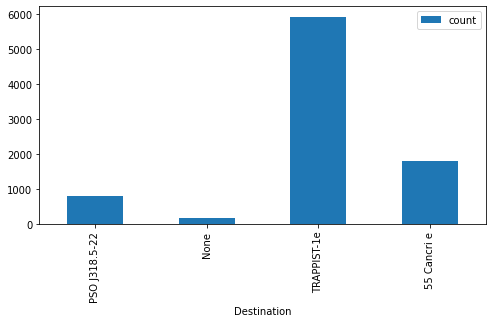

In [14]:
group_dest = df_train.groupBy("Destination").count()
group_dest.toPandas().plot.bar(x='Destination',figsize=(8, 4))
#pandas_df.groupby('Destination').size().plot(kind='pie', autopct='%.2f')

#### Change dtypes

In [15]:
from pyspark.sql.functions import col
from pyspark.sql.types import StringType,BooleanType,DateType, DoubleType, IntegerType
df_train = df_train.withColumn("CryoSleep",col("CryoSleep").cast(BooleanType()).cast(IntegerType()))\
    .withColumn("Age",col("Age").cast(DoubleType()))\
    .withColumn("VIP",col("VIP").cast(BooleanType()).cast(IntegerType()))\
    .withColumn("RoomService", col("RoomService").cast(DoubleType()))\
    .withColumn("FoodCourt", col("FoodCourt").cast(DoubleType()))\
    .withColumn("ShoppingMall", col("ShoppingMall").cast(DoubleType()))\
    .withColumn("Spa", col("Spa").cast(DoubleType()))\
    .withColumn("VRDeck", col("VRDeck").cast(DoubleType()))\
    .withColumn("Transported", col("Transported").cast(BooleanType()).cast(IntegerType()))

#### Drop unnecessary columns

In [16]:
cols = ('Cabin','RoomService', 'FoodCourt', 'Spa', 'Name', 'PassengerId')
df_train = df_train.drop(*cols)
df_train.printSchema()

root
 |-- HomePlanet: string (nullable = true)
 |-- CryoSleep: integer (nullable = true)
 |-- Destination: string (nullable = true)
 |-- Age: double (nullable = true)
 |-- VIP: integer (nullable = true)
 |-- ShoppingMall: double (nullable = true)
 |-- VRDeck: double (nullable = true)
 |-- Transported: integer (nullable = true)



In [17]:
from pyspark.sql.functions import when
from pyspark.sql.functions import regexp_replace

df_train_temp = df_train

df_train = df_train.withColumn('HomePlanet', 
      when(df_train.HomePlanet.startswith('Eart'),regexp_replace(df_train.HomePlanet,'Earth', '0')) \
     .when(df_train.HomePlanet.startswith('Europ'),regexp_replace(df_train.HomePlanet,'Europa','1')) \
     .when(df_train.HomePlanet.startswith('Mar'),regexp_replace(df_train.HomePlanet,'Mars','2')) \
     .otherwise(df_train.HomePlanet))

df_train = df_train.withColumn('Destination', 
      when(df_train.Destination.startswith('TRAPPIST-1e'),regexp_replace(df_train.Destination,'TRAPPIST-1e', '0')) \
     .when(df_train.Destination.startswith('55 Cancri e'),regexp_replace(df_train.Destination,'55 Cancri e','1')) \
     .when(df_train.Destination.startswith('PSO J318.5-22'),regexp_replace(df_train.Destination,'PSO J318.5-22','2')) \
     .otherwise(df_train.Destination))

df_train = df_train.withColumn("Destination",col("Destination").cast(IntegerType()))\
    .withColumn("HomePlanet",col("HomePlanet").cast(IntegerType()))

In [18]:
df_train.printSchema()

root
 |-- HomePlanet: integer (nullable = true)
 |-- CryoSleep: integer (nullable = true)
 |-- Destination: integer (nullable = true)
 |-- Age: double (nullable = true)
 |-- VIP: integer (nullable = true)
 |-- ShoppingMall: double (nullable = true)
 |-- VRDeck: double (nullable = true)
 |-- Transported: integer (nullable = true)



#### Remove null values

In [19]:
df_train = df_train.na.drop("any")
df_train.count()

7396

In [20]:
from pyspark.sql.functions import col,isnan,when,count
df2 = df_train.select([count(when(col(c).contains('None') | \
                            col(c).contains('NULL') | \
                            (col(c) == '' ) | \
                            col(c).isNull() | \
                            isnan(c), c 
                           )).alias(c)
                    for c in df_train.columns])
df2.show()

+----------+---------+-----------+---+---+------------+------+-----------+
|HomePlanet|CryoSleep|Destination|Age|VIP|ShoppingMall|VRDeck|Transported|
+----------+---------+-----------+---+---+------------+------+-----------+
|         0|        0|          0|  0|  0|           0|     0|          0|
+----------+---------+-----------+---+---+------------+------+-----------+



#### Model Building - Random Forest

In [21]:
df_train = df_train.withColumnRenamed('Transported',"label")
features = df_train.columns[0:-1]

In [22]:
from sklearn.metrics import confusion_matrix
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml import Pipeline
from pyspark.ml.tuning import ParamGridBuilder
import numpy as np
from pyspark.ml.tuning import CrossValidator
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

va = VectorAssembler(inputCols = features, outputCol='features')

va_df = va.transform(df_train)
va_df = va_df.select(['features', 'label'])
va_df.show(3)

+--------------------+-----+
|            features|label|
+--------------------+-----+
|(7,[0,3],[1.0,39.0])|    0|
|(7,[3,5,6],[24.0,...|    1|
|[1.0,0.0,0.0,58.0...|    0|
+--------------------+-----+
only showing top 3 rows



#### Split the dataset to train and test

In [23]:
(train, test) = va_df.randomSplit([0.8, 0.2])

In [24]:
rfc = RandomForestClassifier(featuresCol="features", labelCol="label")

paramGrid = ParamGridBuilder() \
    .addGrid(rfc.numTrees, [int(x) for x in np.linspace(start = 10, stop = 50, num = 3)]) \
    .addGrid(rfc.maxDepth, [int(x) for x in np.linspace(start = 5, stop = 25, num = 3)]) \
    .build()

crossval = CrossValidator(estimator=rfc,
                          estimatorParamMaps=paramGrid,
                          evaluator=RegressionEvaluator(),
                          numFolds=3)

cvModel = crossval.fit(train)
predictions = cvModel.transform(test)

22/11/04 23:12:58 WARN DAGScheduler: Broadcasting large task binary with size 1171.2 KiB
22/11/04 23:12:59 WARN DAGScheduler: Broadcasting large task binary with size 1445.2 KiB
22/11/04 23:12:59 WARN DAGScheduler: Broadcasting large task binary with size 1707.7 KiB
22/11/04 23:13:00 WARN DAGScheduler: Broadcasting large task binary with size 1940.0 KiB
22/11/04 23:13:00 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB
22/11/04 23:13:00 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
22/11/04 23:13:01 WARN DAGScheduler: Broadcasting large task binary with size 1256.7 KiB
22/11/04 23:13:03 WARN DAGScheduler: Broadcasting large task binary with size 1171.2 KiB
22/11/04 23:13:04 WARN DAGScheduler: Broadcasting large task binary with size 1445.2 KiB
22/11/04 23:13:04 WARN DAGScheduler: Broadcasting large task binary with size 1707.7 KiB
22/11/04 23:13:04 WARN DAGScheduler: Broadcasting large task binary with size 1940.0 KiB
22/11/04 23:13:05 WARN DAGS

In [25]:
evaluator=MulticlassClassificationEvaluator(predictionCol="prediction")
acc = evaluator.evaluate(predictions)
print("Prediction Accuracy: ", acc)

y_pred=predictions.select("prediction").collect()
y_orig=predictions.select("label").collect()

cm = confusion_matrix(y_orig, y_pred)
print("Confusion Matrix:")
print(cm)

Prediction Accuracy:  0.7583024332040558
Confusion Matrix:
[[569 138]
 [218 549]]


#### Evaluate for test data

In [26]:
cols = ('Cabin','RoomService', 'FoodCourt', 'Spa', 'Name', 'PassengerId')
df_test_cp = df_test
df_test = df_test.drop(*cols)

df_test = df_test.withColumn("CryoSleep",col("CryoSleep").cast(BooleanType()).cast(IntegerType()))\
    .withColumn("Age",col("Age").cast(DoubleType()))\
    .withColumn("VIP",col("VIP").cast(BooleanType()).cast(IntegerType()))\
    .withColumn("ShoppingMall", col("ShoppingMall").cast(DoubleType()))\
    .withColumn("VRDeck", col("VRDeck").cast(DoubleType()))

df_test = df_test.withColumn('HomePlanet', 
      when(df_test.HomePlanet.startswith('Eart'),regexp_replace(df_test.HomePlanet,'Earth', '0')) \
     .when(df_test.HomePlanet.startswith('Europ'),regexp_replace(df_test.HomePlanet,'Europa','1')) \
     .when(df_test.HomePlanet.startswith('Mar'),regexp_replace(df_test.HomePlanet,'Mars','2')) \
     .otherwise(df_test.HomePlanet))

df_test = df_test.withColumn('Destination', 
      when(df_test.Destination.startswith('TRAPPIST-1e'),regexp_replace(df_test.Destination,'TRAPPIST-1e', '0')) \
     .when(df_test.Destination.startswith('55 Cancri e'),regexp_replace(df_test.Destination,'55 Cancri e','1')) \
     .when(df_test.Destination.startswith('PSO J318.5-22'),regexp_replace(df_test.Destination,'PSO J318.5-22','2')) \
     .otherwise(df_test.Destination))

df_test = df_test.withColumn("Destination",col("Destination").cast(IntegerType()))\
    .withColumn("HomePlanet",col("HomePlanet").cast(IntegerType()))

df_test = df_test.fillna(value=0)

df_test.printSchema()

root
 |-- HomePlanet: integer (nullable = true)
 |-- CryoSleep: integer (nullable = true)
 |-- Destination: integer (nullable = true)
 |-- Age: double (nullable = false)
 |-- VIP: integer (nullable = true)
 |-- ShoppingMall: double (nullable = false)
 |-- VRDeck: double (nullable = false)



In [27]:
va = VectorAssembler(inputCols = features, outputCol='features')

va_df_test = va.transform(df_test)
va_df_test = va_df_test.select(['features'])
va_df_test.show(3)

+--------------------+
|            features|
+--------------------+
|(7,[1,3],[1.0,27.0])|
|      (7,[3],[19.0])|
|[1.0,1.0,1.0,31.0...|
+--------------------+
only showing top 3 rows



In [28]:
#cvModel = crossval.fit(train)
y_test_predictions = cvModel.transform(va_df_test)

In [29]:
import pandas as pd
df_test_cp = df_test_cp.toPandas()
y_test_pred = y_test_predictions.toPandas()
data={"PassengerId":df_test_cp['PassengerId'],"Transported":y_test_pred['prediction'].astype('bool')}
data=pd.DataFrame(data)
data=data.to_csv('submission.csv',index=False)

In [30]:
pd.read_csv('./submission.csv')

,PassengerId,Transported
0,0013_01,True
1,0018_01,False
2,0019_01,True
3,0021_01,False
4,0023_01,False
...,...,...
4272,9266_02,True
4273,9269_01,False
4274,9271_01,True
4275,9273_01,False
